---
---
---
# RECURRENT NEURAL NETWORKS (RNN)
---
---
---

---
---
# RNN APPLICATION: PASSENGER NUMBER ESTIMATION
---
---

---
1-) Business Problem (İş Problemi)

2-) Data Understanding (Veriyi Anlamak)

3-) Data Preparation (Veriyi Hazırlamak)

4-) Modelling (Modelleme)

5-) Evalation (Değerlendirme)

6-) Using it to Predict (Tahmin İçin Kullanılması)

---

1-) Business Problem (İş Problemi)

Amaç; geçmiş yıllarda havayolunu kullanan yolcu bilgilerini kullanarak gelecek yılları tahmin etmek.

Aylık yolcu sayıları verilmiştir.

---

* Month: aylık olarak yer alan tarih değişkenidir.
* Passengers: İlgili işlem tarihindeki aylık yolcu sayısı.

2-) Data Understanding (Veriyi Anlamak)

2.1-) Data Understanding (Veriyi Anlamak)

![](CNN_Story_Of_The_Dataset.png)

In [1]:
# GEREKLİ KÜTÜPHANELER

# Veriyi Okuma ve işleme için;
import numpy             as np
import pandas            as pd
import datetime          as dt
import tensorflow        as tf
import matplotlib.pyplot as plt
import random

# Model Değerlendirme için;
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error

# Model için;

from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping

# Warning kapatmak için;
import warnings
warnings.filterwarnings("ignore")

# Tensorflow Warning Engelleme için;
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.2-) Veri Setinin Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [2]:
df = pd.read_csv("international-airline-passengers.csv")

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [5]:
df.columns = ["Month","Passengers"]

In [6]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.shape

(145, 2)

In [9]:
df.size

290

In [10]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [12]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

3-)Data Preparation (Veriyi Hazırlamak)

In [13]:
df = df[:144]

In [14]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [16]:
df["Month"] = pd.to_datetime(df["Month"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [18]:
print("Min Tarih:", df["Month"].min())
print("Max Tarih:", df["Month"].max())

Min Tarih: 1949-01-01 00:00:00
Max Tarih: 1960-12-01 00:00:00


In [19]:
df.index = df["Month"]

In [20]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [21]:
df.drop("Month",axis=1,inplace=True)

In [22]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [23]:
result_df = df.copy()

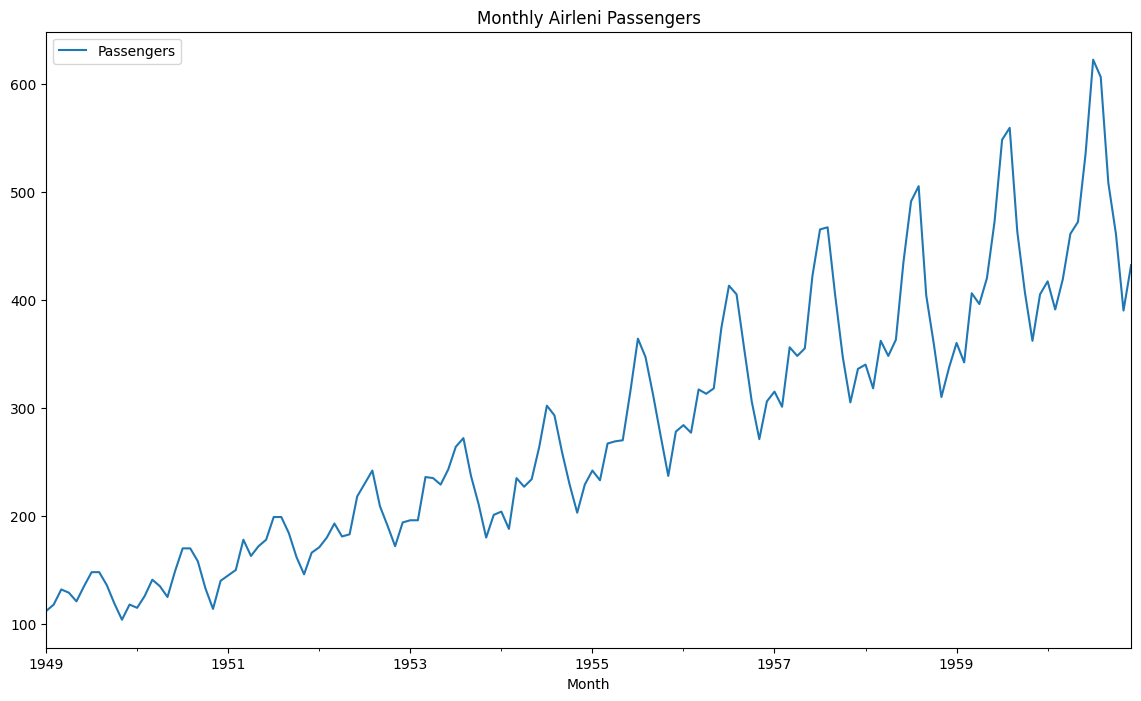

In [24]:
df.plot(figsize=(14,8),title="Monthly Airleni Passengers");

In [25]:
#veriyi numpy array yapma
data = df["Passengers"].values

In [26]:
data[:5]

array([112., 118., 132., 129., 121.])

In [27]:
type(data[:5])

numpy.ndarray

In [28]:
type(data[0])

numpy.float64

In [29]:
# Float16 is a good choice for memory-constrained systems, 
# Float32 is a good balance between accuracy and performance, and 
# Float64 is suitable for high-precision applications.
data = data.astype("float32")

In [30]:
type(data[0])

numpy.float32

In [31]:
data.shape

(144,)

In [32]:
data = data.reshape(-1,1)

In [33]:
data.shape

(144, 1)

2.3-) Train-Test Split

scikit-learn'in train-test split fonksiyonu rastgele ayırır.

Zaman serisinde fazla işe yaramaz.

In [34]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe)*(1-test_size)))
    train    = dataframe[:position]
    test     = dataframe[position:]
    return train,test,position

In [35]:
train,test,position = split_data(data,0.33) #0.33 test, 0.67 train

In [36]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [37]:
#standartlaştırma
scaler_train = MinMaxScaler(feature_range=(0,1))
train        = scaler_train.fit_transform(train)
scaler_test  = MinMaxScaler(feature_range=(0,1))
test         = scaler_test.fit_transform(test)

In [38]:
train[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [39]:
test[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [40]:
# zaman serilerinde veri en çok kendisinden bir önceki veriden etkilenir 
# varsayımı kabul edilmiştir. Bunu da veri setine eklersek;
def create_features(data, lookback):
    X,Y=[],[]
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [41]:
lookback=1

In [42]:
#Train için;
X_train, y_train = create_features(train,lookback)
#Test için;
X_test, y_test =  create_features(test,lookback)

In [43]:
print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [44]:
# RNN için 3 boyutlu veri seti lazım
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [45]:
print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


4-) Modelling (Modelleme)

In [46]:
model = Sequential()

model.add(SimpleRNN(units=50,                                 #nöron sayısı
                    activation='relu',                          
                    input_shape=(X_train.shape[1],lookback))) #boyut bilgisini sinir ağına ifade etmek

#overfitting engellemek için dropout layer

model.add(Dropout(0.2))

#output layer
model.add(Dense(1))

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Optimizasyon ve Değerlendirme Metriklerinin ayarlanması
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
#Overfitting engellemek için ve modelin kaydedilme ayarları için;
callbacks = [EarlyStopping(monitor  ='val_loss',
                           patience =3,
                           verbose  =1,
                           mode     ='min'),
             ModelCheckpoint(filepath          ='mymodel.keras',
                             monitor           ='val_loss',
                             mode              ='min',
                             save_best_only    =True,
                             save_weights_only =False,
                             verbose           =1)]

In [53]:
history = model.fit(x               =X_train,
                    y               =y_train,
                    epochs          =50,
                    batch_size      =1,              #veri gruplarının boyutu
                    validation_data =(X_test,y_test),
                    callbacks       =callbacks,
                    shuffle         =False)          #Optimizasyon işlemi sonunda karıştırma.

Epoch 1/50
71/95 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0052
Epoch 1: val_loss improved from inf to 0.03719, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0372
Epoch 2/50
69/95 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0276
Epoch 2: val_loss improved from 0.03719 to 0.02275, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 - val_loss: 0.0227
Epoch 3/50
82/95 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.0088
Epoch 3: val_loss improved from 0.02275 to 0.02057, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - val_loss: 0.0206
Epoch 4/50
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.0048
Epoch 4: val_loss improved from 0.02057 to 0.02055, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0205
Epoch 5/50
83/95 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 0.0031   
Epoch 5: val_loss did not improve from 0.02055

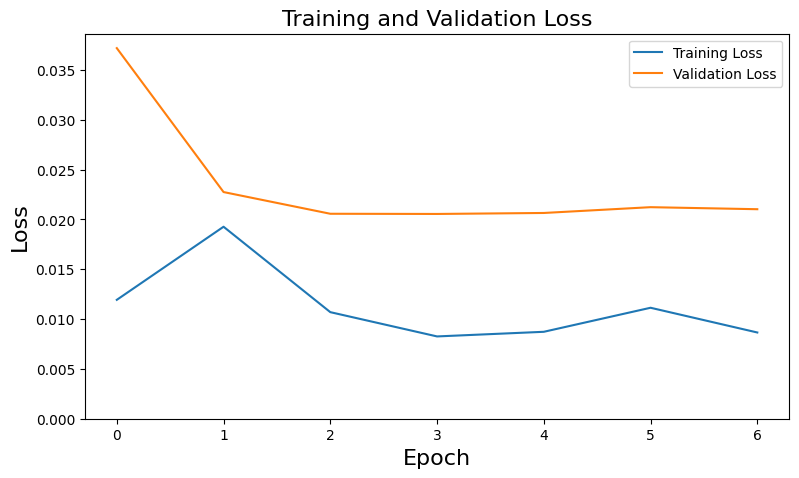

In [54]:
# grafik
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],    label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

5-) Evalation (Değerlendirme)

In [57]:
#Normalleştirilmiş verinin hatası
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest Loss: %.2f%%" % (100.0*loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.0164

Test Loss: 2.10%


In [59]:
#inverse transform
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [60]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict  = scaler_test.inverse_transform(test_predict)

In [61]:
y_train = scaler_train.inverse_transform(y_train)
y_test  = scaler_test.inverse_transform(y_test)

In [67]:
#Train veri setine ait RMSE değeri;
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
#Test veri setine ait RMSE değeri;
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [68]:
print(f"Train RMSE: {train_rmse}")
print(f"Test  RMSE: {test_rmse}")

Train RMSE: 23.495107650756836
Test  RMSE: 46.54465103149414


In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


6-) Using it to Predict (Tahmin İçin Kullanılması)

In [71]:
result_df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [72]:
train_prediction_df = result_df[lookback:position]

In [73]:
train_prediction_df["Predicted"] = train_predict

In [78]:
train_prediction_df.head(100)

,Passengers,Predicted
Month,,
1949-02-01,118.0,130.151550
1949-03-01,132.0,133.726730
1949-04-01,129.0,145.667847
1949-05-01,121.0,142.912033
1949-06-01,135.0,135.821640
...,...,...
1956-08-01,405.0,396.717072
1956-09-01,355.0,390.130402
1956-10-01,306.0,348.466827


In [80]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head(100)

,Passengers,Predicted
Month,,
1957-02-01,301.0,331.501526
1957-03-01,356.0,324.809601
1957-04-01,348.0,368.089355
1957-05-01,355.0,360.740601
1957-06-01,422.0,367.170776
1957-07-01,465.0,428.808289
1957-08-01,467.0,468.404724
1957-09-01,404.0,470.246399
1957-10-01,347.0,412.233032


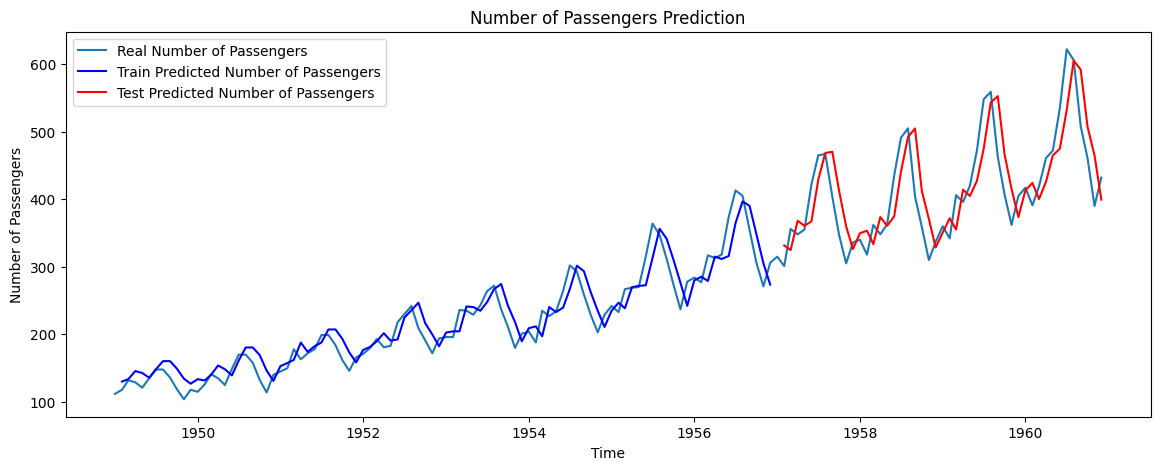

In [81]:
#train ve test tahminlerinin ayrı ayrı görselleştirilme işlemi
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"],color='blue',label = "Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color='red' ,label = "Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()